In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# 위스콘신 유방암 데이터 세트를 훈련, 검증, 테스트 세트로 나누기.

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [3]:
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [4]:
# 배치 경사 하강법

class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z = np.dot(x, self.w) + self.b
    return z

  def backprop(self, x, err):
    m = len(x)
    w_grad = np.dot(x.T, err) / m         # 가중치에 대한 평균 그레이디언트 계산
    b_grad = np.sum(err) / m              # 절편에   대한 평균 그레이디언트 계산
    return w_grad, b_grad

  def activation(self, z):
    a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
    return a
  
  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    m = len(x)
    self.w = np.ones((x.shape[1], 1))    # 가중치 초기화
    self.b = 0                           # 절편 초기화
    self.w_history.append(self.w.copy()) # 가중치 기록

    for i in range(epochs):
      z = self.forpass(x)                # 정방향 계산
      a = self.activation(z)             # 활성화 함수 적용
      err = -(y - a)                     # 오차 계산
      w_grad, b_grad = self.backprop(x, err) # 역방향 계산
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
      self.w -= self.lr * w_grad
      self.b -= self.lr * b_grad
      self.w_history.append(self.w.copy()) # 가중치 기록
      a = np.clip(a, 1e-10, 1-1e-10)
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)

  def predict(self, x):
    z = self.forpass(x)                 # 정방향 계산
    return z > 0                        # 계단(스텝) 함수

  def score(self, x, y):
    return np.mean(self.predict(x) == y.reshape(-1, 1))

  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [5]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [6]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)

0.978021978021978

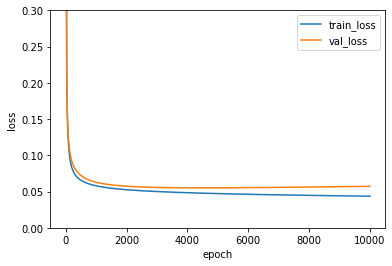

In [7]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

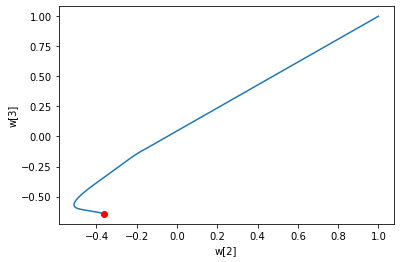

In [8]:
w2 = []
w3 = []
for w in single_layer.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

In [10]:
class DualLayer(SingleLayer):

  def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
    self.units = units # 뉴런 개수    - 은닉층
    self.w1 = None     # 가중치       - 은닉층
    self.b1 = None     # 절편         - 은닉층
    self.w2 = None     # 가중치       - 출력층
    self.b2 = None     # 절편         - 출력층
    self.a1 = None     # 활성화 출력  - 은닉층 
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1         # 첫 번째 층 선형식 계산
    self.a1 = self.activation(z1)             # 활성화 함수 적용
    z2 = np.dot(self.a1, self.w2) + self.b2   # 두 번째 층 선형식 계산
    return z2

  def backprop(self, x, err):
    m = len(x)
    
    # 출력층의 가중치와 절편에 대한 그레이디언트를 계산
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m

    # 시그모이드 함수까지 그레이디언트 계산
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)

    # 은닉층의 가중치와 절편에 대한 그레이디언트를 계산
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  # 가중치 초기화
  def init_weights(self, n_features):
    self.w1 = np.ones((n_features, self.units)) # (특성 개수, 은닉층의 크기)
    self.b1 = np.zeros(self.units) 
    self.w2 = np.ones((self.units, 1))
    self.b2 = 0

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    m = len(x)
    self.init_weights(x.shape[1])
    for i in range(epochs):
      a = self.training(x, y, m)
      a = np.clip(a, 1e-10, 1-1e-10)
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)

  def training(self, x, y, m):
    z = self.forpass(x)
    a = self.activation(z)
    err = -(y - a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m

    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    
    return a

  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
           self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [11]:
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

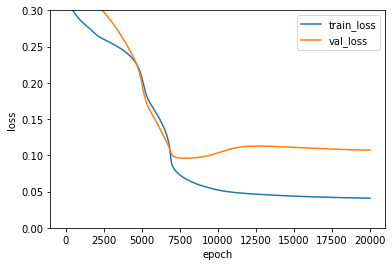

In [12]:
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [19]:
# 가중치 초기화 개선하기

class RandomInitNetwork(DualLayer):

  def init_weights(self, n_features):
    np.random.seed(42) # 값 고정 (실전엔 필요 X)
    self.w1 = np.random.normal(0, 1, (n_features, self.units)) # 랜덤수로 가중치 초기화 (평균, 표준편차, 배열크기)
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0, 1, (self.units, 1))
    self.b2 = 0

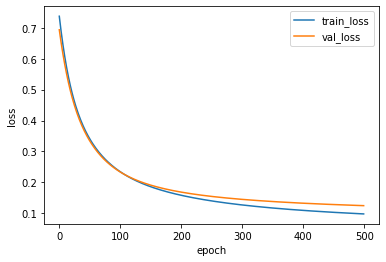

In [22]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)

plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()